In [ ]:
''' 2. Modelagem Preditiva e Benchmarking de Algoritmos
**Objetivo:** Treinar e comparar diferentes arquiteturas de Machine Learning para classificar a qualidade do sono, buscando o equilíbrio ideal entre performance preditiva e custo computacional.

**Arena de Modelos (Complexidade Crescente):**
Neste experimento, submetemos os dados a três paradigmas de aprendizado:
1.  **Baseline (Regressão Logística):** Modelo linear clássico. Serve como referência base; se os modelos complexos não superarem este, não justificam seu uso.
2.  **Ensemble (Random Forest):** Combinação de múltiplas árvores de decisão. Excelente para capturar relações não-lineares e robusto contra *overfitting*.
3.  **Deep Learning (MLP Classifier):** Rede Neural Perceptron Multicamadas. Capaz de modelar interações complexas, mas requer mais dados e ajuste fino.

**Métricas de Decisão:**
* **F1-Score:** Prioridade máxima. Como o dataset pode ter desbalanceamento, a acurácia pura engana. O F1 garante equilíbrio entre *Precision* e *Recall*.
* **ROC-AUC:** Mede a capacidade de distinção entre classes.'''

In [ ]:
%pip -q install xgboost
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    average_precision_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [ ]:
'''2.1. Carregamento de Artefatos
Para garantir a reprodutibilidade e evitar *Data Leakage* (vazamento de dados), carregamos os objetos de pré-processamento e os splits de treino/teste que foram congelados na etapa anterior.
Isso garante que o modelo em produção receberá exatamente o mesmo tratamento de dados que o modelo em treino.'''

In [38]:
preprocessor = joblib.load("../artifacts/preprocessor.joblib")
X_train, X_test, y_train, y_test = joblib.load("../artifacts/splits.joblib")

In [ ]:
'''### 2.2. Modelo Baseline: Regressão Logística
Iniciamos com um modelo linear simples. A Regressão Logística nos permite entender quais features têm correlação linear direta com a qualidade do sono e estabelece o "piso" de performance aceitável.'''

In [39]:
log_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(max_iter=1000, random_state=42))
    ]
)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Logistic Regression
F1: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        78

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



In [ ]:
'''2.3. Challenger 1: Random Forest (Ensemble)
Avançamos para um modelo baseado em árvores. O Random Forest é ideal para este problema pois:
1.  Não assume linearidade nos dados (ex: o impacto do "Stress" no sono pode não ser linear).
2.  Lida bem com interações entre variáveis (ex: Passos + Idade).
3.  O parâmetro `class_weight="balanced"` ajuda a mitigar o desbalanceamento das classes.'''

In [40]:
rf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            class_weight="balanced"
        ))
    ]
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print("F1:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest
F1: 0.9873417721518988
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        35
           1       0.97      1.00      0.99        78

    accuracy                           0.98       113
   macro avg       0.99      0.97      0.98       113
weighted avg       0.98      0.98      0.98       113



In [ ]:
'''2.4. Challenger 2: MLP Classifier (Rede Neural)
Testamos uma arquitetura de Deep Learning (Multi-Layer Perceptron).
* **Estrutura:** Camadas ocultas de (100, 50) neurônios.
* **Objetivo:** Verificar se uma rede neural consegue capturar padrões latentes que as árvores de decisão deixaram passar.'''

In [41]:
mlp = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=500,
            random_state=42
        ))
    ]
)

mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)[:, 1]

print("MLP Classifier")
print("F1:", f1_score(y_test, y_pred_mlp))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_mlp))
print(classification_report(y_test, y_pred_mlp))

MLP Classifier
F1: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        78

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



In [ ]:
'''### 3. Persistência dos Modelos
Salvamos todos os modelos treinados na pasta `artifacts`. Isso permite que a aplicação final (App Streamlit ou API) carregue o "vencedor" sem precisar retreinar tudo do zero.'''

In [42]:

xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", XGBClassifier(
            n_estimators=400,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            eval_metric="logloss",
            n_jobs=-1
        ))
    ]
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost")
print("F1:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost
F1: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        78

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



In [43]:

def full_metrics(y_true, y_pred, y_score):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_true, y_score),
        "PR_AUC": average_precision_score(y_true, y_score),
    }


In [44]:
results = []

results.append({"Model": "LogReg", **full_metrics(y_test, y_pred, y_proba)})
results.append({"Model": "RandomForest", **full_metrics(y_test, y_pred_rf, y_proba_rf)})
results.append({"Model": "MLP", **full_metrics(y_test, y_pred_mlp, y_proba_mlp)})
results.append({"Model": "XGBoost", **full_metrics(y_test, y_pred_xgb, y_proba_xgb)})

df_results = (
    pd.DataFrame(results)
    .set_index("Model")
    .sort_values("PR_AUC", ascending=False)
)
print(df_results)

              Accuracy  Precision  Recall        F1  ROC_AUC  PR_AUC
Model                                                               
RandomForest  0.982301      0.975     1.0  0.987342      1.0     1.0
MLP           1.000000      1.000     1.0  1.000000      1.0     1.0
XGBoost       1.000000      1.000     1.0  1.000000      1.0     1.0
LogReg        1.000000      1.000     1.0  1.000000      1.0     1.0


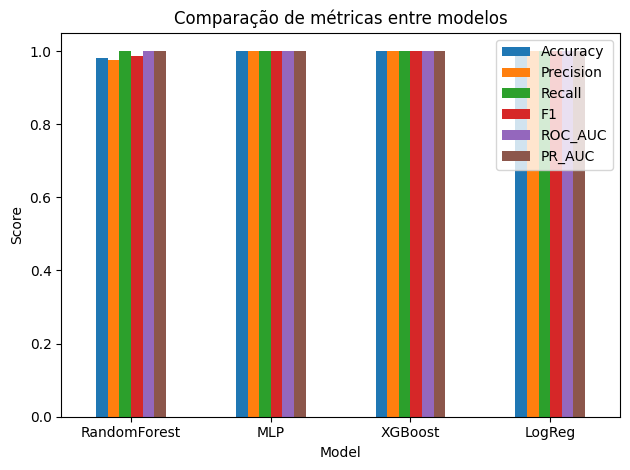

In [45]:
ax = df_results[
    ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "PR_AUC"]
].plot(kind="bar", rot=0)

ax.set_title("Comparação de métricas entre modelos")
ax.set_ylabel("Score")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

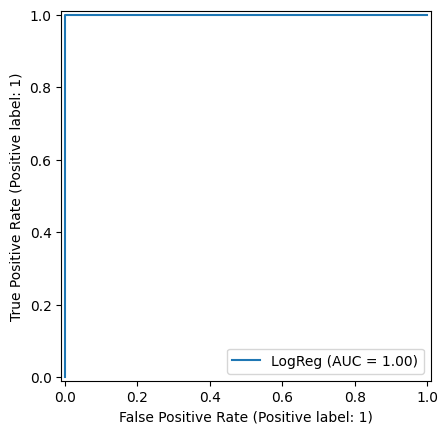

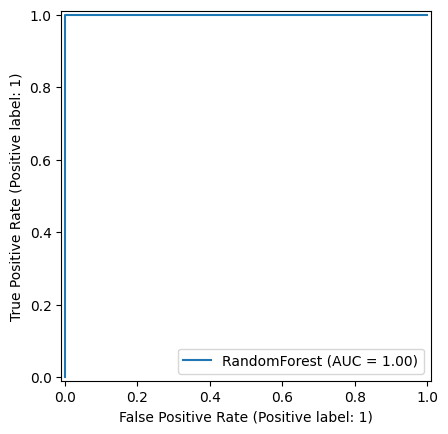

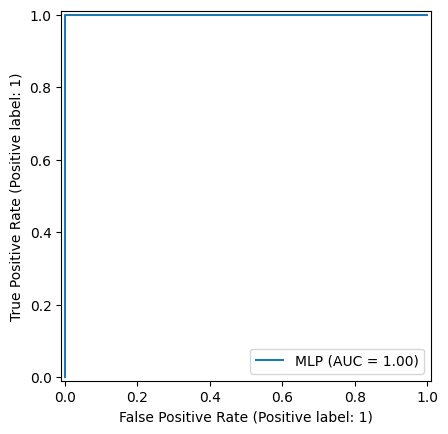

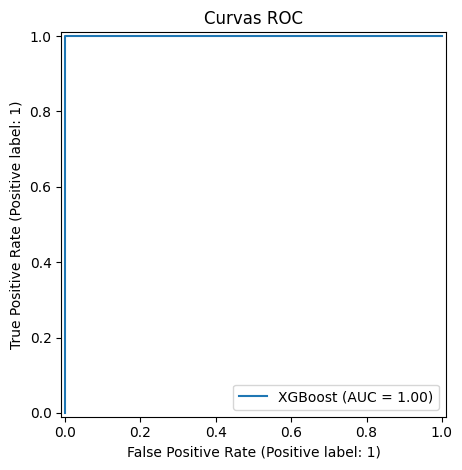

In [46]:

plt.figure()
RocCurveDisplay.from_estimator(log_reg, X_test, y_test, name="LogReg")
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="RandomForest")
RocCurveDisplay.from_estimator(mlp, X_test, y_test, name="MLP")
RocCurveDisplay.from_estimator(xgb, X_test, y_test, name="XGBoost")
plt.title("Curvas ROC")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

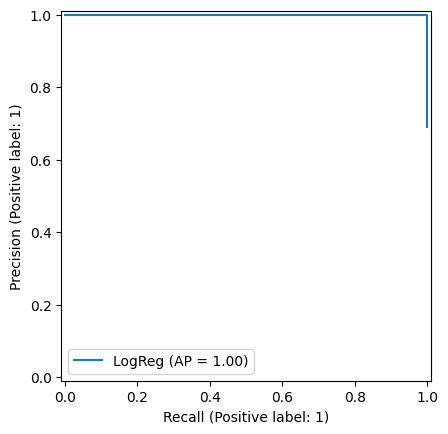

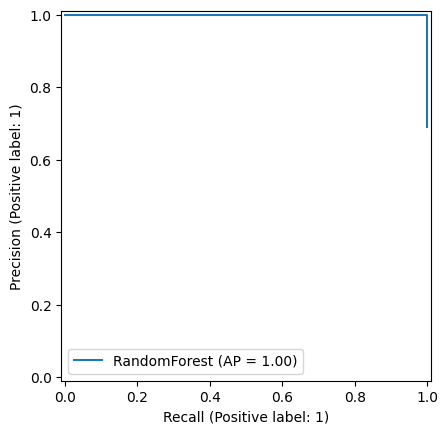

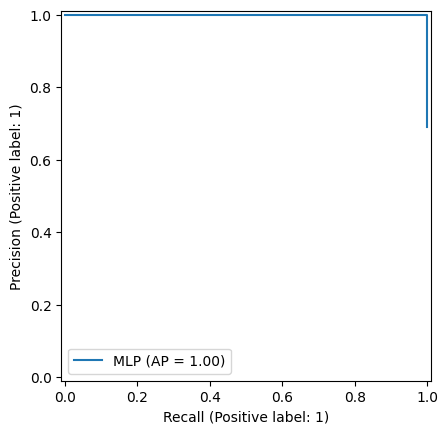

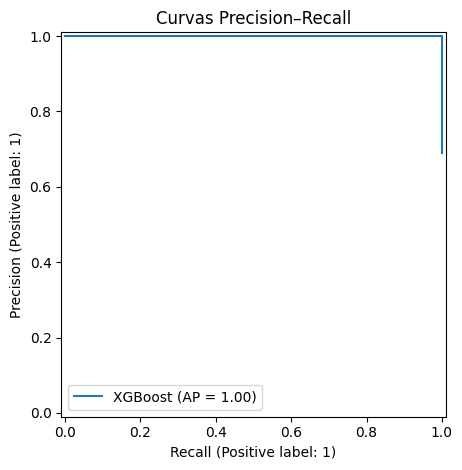

In [47]:
plt.figure()
PrecisionRecallDisplay.from_estimator(log_reg, X_test, y_test, name="LogReg")
PrecisionRecallDisplay.from_estimator(rf, X_test, y_test, name="RandomForest")
PrecisionRecallDisplay.from_estimator(mlp, X_test, y_test, name="MLP")
PrecisionRecallDisplay.from_estimator(xgb, X_test, y_test, name="XGBoost")
plt.title("Curvas Precision–Recall")
plt.tight_layout()
plt.show()

Melhor modelo (PR_AUC): RandomForest


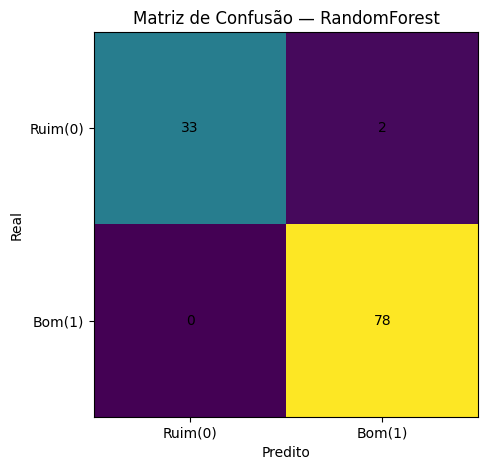

In [48]:
best_model_name = df_results["PR_AUC"].idxmax()
print("Melhor modelo (PR_AUC):", best_model_name)

model_map = {
    "LogReg": log_reg,
    "RandomForest": rf,
    "MLP": mlp,
    "XGBoost": xgb
}

best_model = model_map[best_model_name]
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)

plt.figure()
plt.imshow(cm)
plt.title(f"Matriz de Confusão — {best_model_name}")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.xticks([0,1], ["Ruim(0)", "Bom(1)"])
plt.yticks([0,1], ["Ruim(0)", "Bom(1)"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [49]:

joblib.dump(xgb, "../artifacts/xgb.joblib")
df_results.to_csv("../artifacts/benchmark_metrics.csv")

print("Benchmark salvo em artifacts/")

Benchmark salvo em artifacts/
